# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

<ipython-input-3-0db367189513>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
<ipython-input-3-0db367189513>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0


# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_in
Gradient check passed!
Checking gradient for B_in
Gradient check passed!
Checking gradient for W_out
Gradient check passed!
Checking gradient for B_out
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_in
Gradient check passed!
Checking gradient for B_in
Gradient check passed!
Checking gradient for W_out
Gradient check passed!
Checking gradient for B_out
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

**Ответ:** около 0.1, поскольку сеть еше не тренирована

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [9]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-3)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, loss: 2.291236, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1, loss: 2.277068, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2, loss: 2.261643, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 3, loss: 2.289942, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 4, loss: 2.260467, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 5, loss: 2.223411, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 6, loss: 2.312400, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 7, loss: 2.246598, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 8, loss: 2.273079, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 9, loss: 2.233200, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 10, loss: 2.241732, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 11, loss: 2.289773, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 12, loss: 2.297524, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 13, loss: 2.266

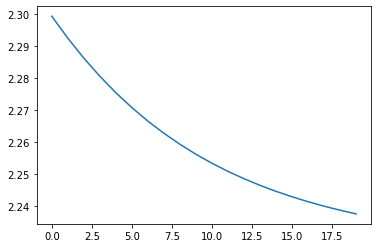

In [10]:
plt.plot(loss_history);

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [11]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-3, learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Epoch: 0, loss: 2.294697, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1, loss: 2.309085, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2, loss: 2.279445, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 3, loss: 2.283792, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 4, loss: 2.262690, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 5, loss: 2.260904, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 6, loss: 2.231392, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 7, loss: 2.295788, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 8, loss: 2.290340, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 9, loss: 2.287723, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 10, loss: 2.229048, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 11, loss: 2.265880, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 12, loss: 2.320411, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 13, loss: 2.195

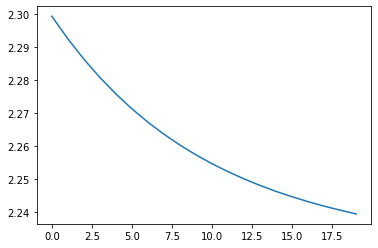

In [12]:
plt.plot(loss_history);

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [13]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-3, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, loss: 2.252894, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1, loss: 2.197964, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2, loss: 2.315294, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 3, loss: 2.004477, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 4, loss: 2.090921, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 5, loss: 2.321708, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 6, loss: 2.096080, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 7, loss: 2.174662, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 8, loss: 2.104533, train accuracy: 0.198333, val accuracy: 0.209000
Epoch: 9, loss: 2.124325, train accuracy: 0.222889, val accuracy: 0.226000
Epoch: 10, loss: 2.045311, train accuracy: 0.251667, val accuracy: 0.256000
Epoch: 11, loss: 2.103846, train accuracy: 0.261778, val accuracy: 0.261000
Epoch: 12, loss: 1.813391, train accuracy: 0.273667, val accuracy: 0.270000
Epoch: 13, loss: 2.039

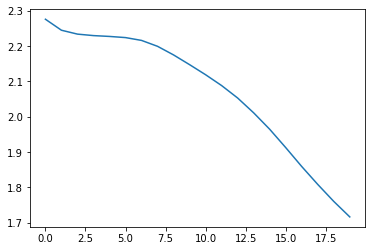

In [14]:
plt.plot(loss_history);

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [15]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, loss: 2.351801, train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 1, loss: 2.319693, train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 2, loss: 2.295926, train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 3, loss: 2.345443, train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 4, loss: 2.310013, train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 5, loss: 2.326544, train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 6, loss: 2.255641, train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 7, loss: 2.199259, train accuracy: 0.200000, val accuracy: 0.066667
Epoch: 8, loss: 2.164561, train accuracy: 0.333333, val accuracy: 0.066667
Epoch: 9, loss: 2.025661, train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 10, loss: 1.883798, train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 11, loss: 2.263931, train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 12, loss: 1.662918, train accuracy: 0.333333, val accuracy: 0.000000
Epoch: 13, loss: 2.245

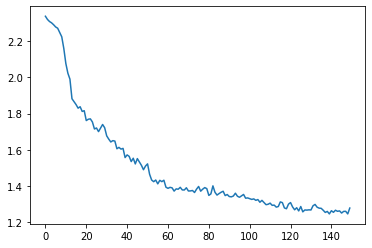

In [16]:
plt.plot(loss_history);

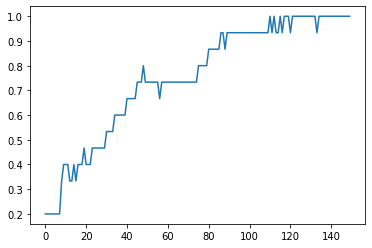

In [17]:
plt.plot(train_history);

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [18]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 420, reg = 1e-6)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-1, num_epochs=20, batch_size=10)

loss_history, train_history, val_history = trainer.fit()

Epoch: 0, loss: 2.302515, train accuracy: 0.333333, val accuracy: 0.066667
Epoch: 1, loss: 2.290278, train accuracy: 0.200000, val accuracy: 0.133333
Epoch: 2, loss: 2.198815, train accuracy: 0.266667, val accuracy: 0.000000
Epoch: 3, loss: 2.308215, train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 4, loss: 2.140382, train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 5, loss: 1.947153, train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 6, loss: 1.349985, train accuracy: 0.333333, val accuracy: 0.000000
Epoch: 7, loss: 1.304975, train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 8, loss: 1.199675, train accuracy: 0.400000, val accuracy: 0.133333
Epoch: 9, loss: 0.433688, train accuracy: 0.466667, val accuracy: 0.000000
Epoch: 10, loss: 0.846994, train accuracy: 0.600000, val accuracy: 0.000000
Epoch: 11, loss: 2.389057, train accuracy: 0.600000, val accuracy: 0.000000
Epoch: 12, loss: 0.707858, train accuracy: 0.666667, val accuracy: 0.066667
Epoch: 13, loss: 0.851

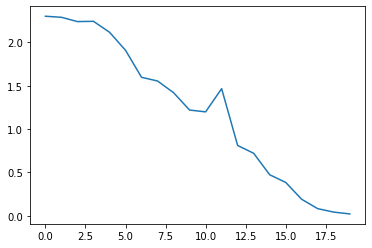

In [19]:
plt.plot(loss_history);

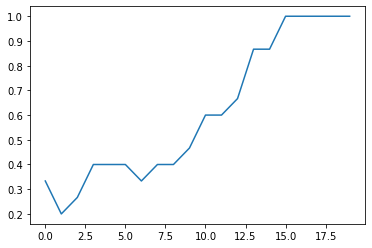

In [20]:
plt.plot(train_history);

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [21]:
from itertools import product

# Let's train the best one-hidden-layer network we can

learning_rates = [1e-1, 1e-2]
reg_strength = [1e-4, 1e-5]
learning_rate_decay = [0.9]
hidden_layer_size = [256, 512]
num_epochs = 20
batch_size = [256]

best_classifier = None
best_val_accuracy = 0

loss_history = []
train_history = []
val_history = []

dataset = Dataset(train_X, train_y, val_X, val_y)

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

learning_suites = [
    learning_rates,
    reg_strength,
    learning_rate_decay,
    hidden_layer_size,
    batch_size
]

best_learning_suite = None

for lr, rs, lrd, hls, bs in product(*learning_suites):
    model = TwoLayerNet(n_input=train_X.shape[1],
                        n_output=10,
                        hidden_layer_size=hls,
                        reg=rs
                        )
    trainer = Trainer(model, dataset, MomentumSGD(),
                      learning_rate=lr,
                      learning_rate_decay=lrd,
                      num_epochs=num_epochs,
                      batch_size=bs
                      )
    ls_loss_history, ls_train_history, ls_val_history = trainer.fit()

    if ls_val_history[-1] > best_val_accuracy:
        best_classifier = model
        best_val_accuracy = ls_val_history[-1]
        best_learning_suite = [(lr, rs, lrd, hls, bs)]
        loss_history = ls_loss_history.copy()
        train_history = ls_train_history.copy()
        val_history = ls_val_history.copy()

    for best_lr, best_rs, best_lrd, best_hls, best_bs in best_learning_suite:
        print(f'Best learning suite: '
              f'best learning rate: {best_lr} '
              f'best regularization strength: {best_rs} '
              f'best learning rate decay: {best_lrd} '
              f'best hidden layer size: {best_hls} '
              f'best batch size: {best_bs} '
              )
    print(f'Best validation accuracy: {best_val_accuracy}')

print(f'Best validation accuracy achieved: {best_val_accuracy}')

Epoch: 0, loss: 2.179032, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1, loss: 2.155399, train accuracy: 0.223333, val accuracy: 0.232000
Epoch: 2, loss: 1.847522, train accuracy: 0.331444, val accuracy: 0.352000
Epoch: 3, loss: 1.594995, train accuracy: 0.457556, val accuracy: 0.455000
Epoch: 4, loss: 1.508542, train accuracy: 0.538556, val accuracy: 0.536000
Epoch: 5, loss: 1.094075, train accuracy: 0.612556, val accuracy: 0.608000
Epoch: 6, loss: 1.004210, train accuracy: 0.636889, val accuracy: 0.605000
Epoch: 7, loss: 0.958955, train accuracy: 0.682444, val accuracy: 0.665000
Epoch: 8, loss: 0.989820, train accuracy: 0.707889, val accuracy: 0.676000
Epoch: 9, loss: 1.107912, train accuracy: 0.729444, val accuracy: 0.697000
Epoch: 10, loss: 0.849067, train accuracy: 0.727333, val accuracy: 0.701000
Epoch: 11, loss: 0.552901, train accuracy: 0.751000, val accuracy: 0.706000
Epoch: 12, loss: 1.019565, train accuracy: 0.754333, val accuracy: 0.713000
Epoch: 13, loss: 0.693

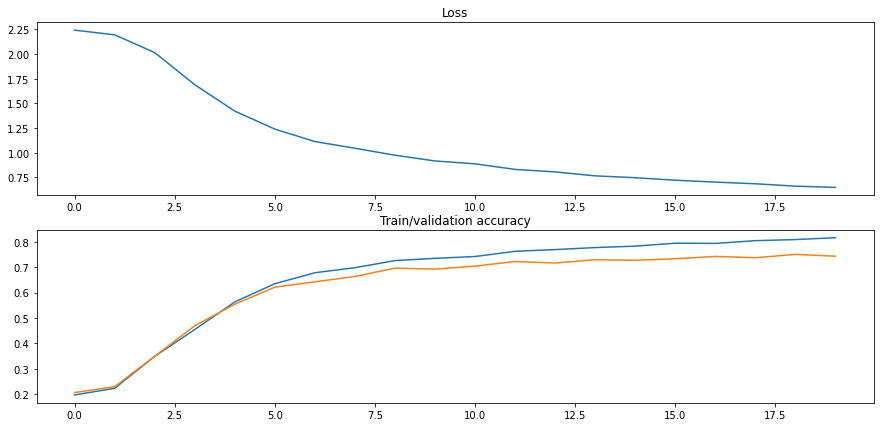

In [22]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [23]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.710000
